In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
from collections import namedtuple
from gensim.models import doc2vec
from gensim.similarities import docsim
from gensim import corpora
import itertools
from string import punctuation, digits
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, Legend, HoverTool
from bokeh.palettes import all_palettes
from pandas_datareader.data import DataReader
from datetime import date

In [95]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as py
import plotly.graph_objs as go
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as FF
import time

## Data Scraping

### Scraping 10Ks from EDGAR

In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen


def table_extractor(soup):
    """Extract the tables from a soup object"""
    for table in soup.find_all("table"):
        table.extract()
    return soup


sp_500_wiki_link = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
soup_wiki = BeautifulSoup(urlopen(sp_500_wiki_link), 'html.parser')
table_wiki = soup_wiki.find("table", {"class": "wikitable sortable"})

# Fail now if the right table hasn't been found
header = table_wiki.findAll('th')
if header[0].string != "Ticker symbol" or header[1].string != "Security":
    raise Exception("Can't parse wikipedia's table!")

# Retreive the values in the table
records = []
rows = table_wiki.findAll('tr')
for row in rows:
    fields = row.findAll('td')
    if fields:
        # Get info and SEC company link
        symbol = fields[0].string
        wiki_link = "https://en.wikipedia.org/wiki" + fields[1].a.get('href')
        CIK = fields[7].string
        sec_company_link = "https://www.sec.gov/cgi-bin/browse-edgar?" + \
                           "action=getcompany&CIK=" + CIK + \
                           "&type=10-K&dateb=&owner=include&count=40"
        name = fields[1].a.string
        sector = fields[3].string

        # Get link for the page with latest 10-K related filings
        soup_comp = BeautifulSoup(urlopen(sec_company_link), 'html.parser')
        table_comp = soup_comp.find("table", {"class": "tableFile2"})
        try:
            # Get the latest filing page
            filings_link = "https://www.sec.gov" + \
                                table_comp.a.get('href')

            # Get the link for the latest 10K
            soup_filings = BeautifulSoup(urlopen(filings_link),
                                         'html.parser')
            table_filings = soup_filings.find("table", {"class": "tableFile"})
            _10K_link = "https://www.sec.gov" + table_filings.a.get('href')

            # Extracting the text from the latest 10K
            try:
                soup_latest_10K = BeautifulSoup(urlopen(_10K_link).read(),
                                                'html.parser')
                soup_latest_10K = table_extractor(soup_latest_10K)
                _latest_10K_txt = soup_latest_10K.get_text()

            except:
                # If the latest 10K is not available, return N/A
                _latest_10K_txt = np.nan

        except:
            # If the filings are not available, return N/A
            _10K_link = np.nan
            _latest_10K_txt = np.nan

        # Append results
        records.append([symbol, wiki_link, name, sector, sec_company_link,
                        CIK, _latest_10K_txt])

headers = ['Symbol', 'Wikipedia Link', 'Name', 'Sector', 'SEC Filings Link',
           'CIK', 'Latest 10K']
data = pd.DataFrame(records, columns=headers)

# Correct ambiguous tickers for later purpose
ambiguous_tickers = ['BRK.B', 'BF.B']
corrected_tickers = ['BRK-B', 'BF-B']

for i, ticker in enumerate(ambiguous_tickers):
    data['Symbol'] = data['Symbol'].replace(ticker, corrected_tickers[i])

### Scraping Fundamentals from Yahoo! Finance

In [11]:
def unit_converter(data):
    billion = 1_000_000_000
    million = 1_000_000
    if data[-1] == 'B':
        return float(data[:-1])*billion
    elif data[-1] == 'M':
        return float(data[:-1])*million
    else:
        return float(data)


items = ['Enterprise Value', 'Enterprise Value/Revenue', 'Diluted EPS',
         'Enterprise Value/EBITDA', 'Revenue', 'EBITDA', 'Trailing P/E',
         'Market Cap (intraday)', 'Forward P/E', 'Beta', 
         '50-Day Moving Average', '200-Day Moving Average',
         'Avg Vol (3 month)', 'Avg Vol (10 day)', 'Shares Outstanding', 
         '% Held by Insiders', '% Held by Institutions',
         'Forward Annual Dividend Yield']

for i, ticker in enumerate(data['Symbol']):
    key_stats_link = 'https://finance.yahoo.com/quote/' + ticker + \
                     '/key-statistics?p=' + ticker
    key_stats_soup = BeautifulSoup(urlopen(key_stats_link).read(),
                                   'html.parser').findAll('td')
    for j, row in enumerate(key_stats_soup):
        for item in items:
            try:
                if item == row.span.string:
                    # Dangerous assumption
                    data.loc[i, item] = \
                    unit_converter(key_stats_soup[j+1].string)
            except:
                next

In [ ]:
# Testing the same thing on Zacks' site

items = ['Enterprise Value', 'Enterprise Value/Revenue', 'Diluted EPS',
         'Enterprise Value/EBITDA', 'Revenue', 'EBITDA', 'Trailing P/E',
         'Market Cap (intraday)', 'Forward P/E', 'Beta', 
         '50-Day Moving Average', '200-Day Moving Average',
         'Avg Vol (3 month)', 'Avg Vol (10 day)', 'Shares Outstanding', 
         '% Held by Insiders', '% Held by Institutions',
         'Forward Annual Dividend Yield']

for i, ticker in enumerate(data['Symbol']):
    key_stats_link = 'https://finance.yahoo.com/quote/' + ticker + \
                     '/key-statistics?p=' + ticker
    key_stats_soup = BeautifulSoup(urlopen(key_stats_link).read(),
                                   'html.parser').findAll('td')
    for j, row in enumerate(key_stats_soup):
        for item in items:
            try:
                if item == row.span.string:
                    # Dangerous assumption
                    data.loc[i, item] = \
                    unit_converter(key_stats_soup[j+1].string)
            except:
                next

Disclaimer: This scraper makes an important assumption regarding the structure of the html file. Specifically, it assumes that the data for each item of interest is the string of text located in the 'td' tag following the one where the name of the item was found.

### Scraping Historical Prices from Yahoo! Finance


This no longer works...

In [12]:
# Uncomment to save the data
data.to_csv('10K_data.csv')
# historical_prices_panel['Close'].to_csv('close_price_data.csv')
# historical_prices_panel['Open'].to_csv('open_price_data.csv')

## Data Cleaning and Preprocessing

In [3]:
cd ..

/home/wbaik/Code/data_science/temp_folder


In [4]:
# Uncomment to read the data
data = pd.read_csv('10K_data.csv')
# close_price = pd.read_csv('close_price_data.csv')
# open_price = pd.read_csv('open_price_data.csv')

In [168]:
# Remove companies without filings
no_filings_data = data[data['Latest 10K'].isnull()]
data = data[~data['Latest 10K'].isnull()]

# Remove duplicates (keep first)
data = data.drop_duplicates(keep='first')

# Drop Google duplicate
data = data[data['Symbol'] != 'GOOG']

# Drop NA rows (about 60 companies)
# data = data.dropna()

# Drop companies with negative EPS or EBITDA (about 30 companies)
# data = data[(data[['EBITDA', 'Diluted EPS']] > 0).all(1)]

# Reset index
data = data.reset_index(drop=True)

In [5]:
data.groupby('Sector').groups.keys()

dict_keys(['Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Telecommunication Services', 'Utilities'])

In [6]:
grouped_by_sector = {}
group_by_obj = data.groupby('Sector')
for sector in group_by_obj.groups.keys():
    grouped_by_sector[sector] = group_by_obj.get_group(sector)

In [7]:
grouped_by_sector.keys()

dict_keys(['Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Telecommunication Services', 'Utilities'])

In [8]:
grouped_by_sector['Energy']['Symbol'][:10]

38     ANDV
43      APA
74      COG
91      CVX
96      XEC
107     CXO
122     DVN
142     EOG
143     EQT
155     XOM
Name: Symbol, dtype: object

In [9]:
data.groupby('Sector').get_group('Information Technology').sort_values(by=['Trailing P/E'])[:5]

,Unnamed: 0,Symbol,Wikipedia Link,Name,Sector,SEC Filings Link,CIK,Latest 10K,Enterprise Value,Trailing P/E,...,EBITDA,Diluted EPS,Market Cap (intraday),Forward P/E,Beta,50-Day Moving Average,200-Day Moving Average,Avg Vol (3 month),Avg Vol (10 day),Shares Outstanding
262,262,MU,https://en.wikipedia.org/wiki/wiki/Micron_Tech...,Micron Technology,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,723125,\n10-K\n1\na2017q4.htm\n10-K\n\n\n\n\n\n\nDocu...,7.360000e+10,7.57,...,1.290000e+10,6.40,5.620000e+10,4.91,1.62,52.91,45.01,53970000.0,64070000.0,1.160000e+09
197,197,HPQ,https://en.wikipedia.org/wiki/wiki/HP_Inc.,HP Inc.,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,47217,\n10-K/A\n1\nhp-103117x10ka.htm\n10-K/A\n\n\n\...,3.806000e+10,9.15,...,4.520000e+09,2.27,3.411000e+10,9.94,1.91,22.73,21.76,11060000.0,9220000.0,1.640000e+09
70,70,AVGO,https://en.wikipedia.org/wiki/wiki/Broadcom_Li...,Broadcom,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1441634,\n10-K\n1\navgo-110115x10k.htm\n10-K\n\n\n\n\n...,1.105600e+11,12.47,...,8.220000e+09,18.35,9.906000e+10,10.99,0.60,247.58,254.33,4200000.0,4820000.0,4.107400e+08
21,21,ADS,https://en.wikipedia.org/wiki/wiki/Alliance_Da...,Alliance Data Systems,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1101215,\n10-K\n1\nads-20171231x10k.htm\n10-K\n\n\n\n\...,3.385000e+10,14.59,...,1.740000e+09,14.10,1.141000e+10,7.98,1.70,229.40,236.14,NaN,1090000.0,5.546000e+07
353,353,SYMC,https://en.wikipedia.org/wiki/wiki/Symantec_Corp.,Symantec Corp.,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,849399,\n10-K/A\n1\nd430795d10ka.htm\nFORM 10-K/A\n\n...,1.912000e+10,16.07,...,8.590000e+08,1.62,1.616000e+10,14.36,0.85,26.73,28.80,6560000.0,5380000.0,6.215400e+08


In [10]:
bins = np.arange(-2,5,0.5)
labels = pd.cut(data['Beta'], bins)

In [11]:
labels.name = 'beta_cut'

In [12]:
data_with_labels = pd.concat([data, labels], axis=1)

In [13]:
EV_min = min(data['Enterprise Value']) - 10
EV_max = max(data['Enterprise Value'])

ev_bin_diff = (EV_max - EV_min) / 10.0
EV_max += ev_bin_diff # Need this to offset one off

EV_bins = np.arange(EV_min, EV_max, ev_bin_diff)

ev_labels = pd.cut(data['Enterprise Value'], EV_bins)
ev_labels.name = 'Enterprise_Value_Cuts'
data_with_EV_labels = pd.concat([data, ev_labels], axis=1)

In [14]:
data_with_EV_labels[data_with_EV_labels['Enterprise_Value_Cuts'].isnull()]

,Unnamed: 0,Symbol,Wikipedia Link,Name,Sector,SEC Filings Link,CIK,Latest 10K,Enterprise Value,Trailing P/E,...,Diluted EPS,Market Cap (intraday),Forward P/E,Beta,50-Day Moving Average,200-Day Moving Average,Avg Vol (3 month),Avg Vol (10 day),Shares Outstanding,Enterprise_Value_Cuts


In [15]:
grouped_by_pe = pd.qcut(data['Forward P/E'], 10)

In [16]:
grouped_by_pe[:10]

0    (17.758, 19.564]
1    (17.758, 19.564]
2    (10.184, 11.612]
3    (19.564, 21.882]
4    (19.564, 21.882]
5      (13.4, 14.642]
6    (28.898, 120.79]
7    (17.758, 19.564]
8      (14.642, 15.9]
9      (13.4, 14.642]
Name: Forward P/E, dtype: category
Categories (10, interval[float64]): [(4.909, 10.184] < (10.184, 11.612] < (11.612, 13.4] < (13.4, 14.642] ... (17.758, 19.564] < (19.564, 21.882] < (21.882, 28.898] < (28.898, 120.79]]

In [17]:
pd.get_dummies(grouped_by_pe)[:10]

,"(4.909, 10.184]","(10.184, 11.612]","(11.612, 13.4]","(13.4, 14.642]","(14.642, 15.9]","(15.9, 17.758]","(17.758, 19.564]","(19.564, 21.882]","(21.882, 28.898]","(28.898, 120.79]"
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,1,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0


In [21]:
# iterables are what to retrieve from the given_dataframe 
# to cut into different `size`
def add_columns_by_cuts(iterables, given_dataframe, size):
    
    def create_labels(size):
        return ['{}% ranked'.format(i/size*100) for i in range(size)]
    
    labels = create_labels(size)
    
    new_dataframe = None
    
    for cur in iterables:
        new_name = cur + '_qcut'
        if new_dataframe is None:
            cutted = pd.qcut(given_dataframe[cur], size, precision=2, labels=labels)
            cutted.name = new_name
            new_dataframe = pd.concat([given_dataframe['Symbol'], cutted], axis=1)
        else:
            new_dataframe[new_name] = pd.qcut(given_dataframe[cur], size, precision=2, labels=labels)
    
    new_dataframe = pd.concat([new_dataframe, given_dataframe], axis=1)
    
    return new_dataframe

In [87]:
neo_data = add_columns_by_cuts(['Trailing P/E', 'Enterprise Value'], data, 10)

In [88]:
neo_data[:7]

,Symbol,Trailing P/E_qcut,Enterprise Value_qcut,Unnamed: 0,Symbol,Wikipedia Link,Name,Sector,SEC Filings Link,CIK,...,EBITDA,Diluted EPS,Market Cap (intraday),Forward P/E,Beta,50-Day Moving Average,200-Day Moving Average,Avg Vol (3 month),Avg Vol (10 day),Shares Outstanding
0,MMM,60.0% ranked,90.0% ranked,0,MMM,https://en.wikipedia.org/wiki/wiki/3M,3M Company,Industrials,https://www.sec.gov/cgi-bin/browse-edgar?actio...,66740,...,8.880000e+09,7.93,1.262300e+11,18.50,1.02,230.23,231.49,2720000.0,2850000.0,5.947100e+08
1,ABT,90.0% ranked,90.0% ranked,1,ABT,https://en.wikipedia.org/wiki/wiki/Abbott_Labo...,Abbott Laboratories,Health Care,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1800,...,5.960000e+09,0.27,1.005400e+11,17.88,1.71,60.67,57.43,7160000.0,6600000.0,1.750000e+09
2,ABBV,60.0% ranked,90.0% ranked,2,ABBV,https://en.wikipedia.org/wiki/wiki/AbbVie_Inc.,AbbVie Inc.,Health Care,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1551152,...,1.214000e+10,3.30,1.424500e+11,10.28,1.49,113.10,100.42,7180000.0,11980000.0,1.590000e+09
3,ACN,50.0% ranked,80.0% ranked,3,ACN,https://en.wikipedia.org/wiki/wiki/Accenture_plc,Accenture plc,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1467373,...,5.850000e+09,5.64,9.478000e+10,20.13,1.00,157.52,150.54,2510000.0,2660000.0,6.430900e+08
4,ATVI,90.0% ranked,70.0% ranked,4,ATVI,https://en.wikipedia.org/wiki/wiki/Activision_...,Activision Blizzard,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,718877,...,2.230000e+09,0.36,4.898000e+10,21.52,0.72,71.30,66.61,7060000.0,8010000.0,7.586300e+08
5,AYI,30.0% ranked,0.0% ranked,5,AYI,https://en.wikipedia.org/wiki/wiki/Acuity_Bran...,Acuity Brands Inc,Industrials,https://www.sec.gov/cgi-bin/browse-edgar?actio...,1144215,...,5.975000e+08,7.27,5.350000e+09,13.52,1.26,144.57,159.74,NaN,1390000.0,4.055000e+07
6,ADBE,80.0% ranked,80.0% ranked,6,ADBE,https://en.wikipedia.org/wiki/wiki/Adobe_Syste...,Adobe Systems Inc,Information Technology,https://www.sec.gov/cgi-bin/browse-edgar?actio...,796343,...,2.720000e+09,3.75,1.076600e+11,29.86,0.85,215.41,185.80,3160000.0,3870000.0,4.924700e+08


In [89]:
neo_data.keys()

Index(['Symbol', 'Trailing P/E_qcut', 'Enterprise Value_qcut', 'Unnamed: 0',
       'Symbol', 'Wikipedia Link', 'Name', 'Sector', 'SEC Filings Link', 'CIK',
       'Latest 10K', 'Enterprise Value', 'Trailing P/E',
       'Enterprise Value/Revenue', 'Enterprise Value/EBITDA', 'Revenue',
       'EBITDA', 'Diluted EPS', 'Market Cap (intraday)', 'Forward P/E', 'Beta',
       '50-Day Moving Average', '200-Day Moving Average', 'Avg Vol (3 month)',
       'Avg Vol (10 day)', 'Shares Outstanding'],
      dtype='object')

In [90]:
c1, c2 = 'Trailing P/E_qcut', 'Enterprise Value_qcut'
neo_data.groupby([c1,c2]).mean()['Revenue'].unstack()

Enterprise Value_qcut,0.0% ranked,10.0% ranked,20.0% ranked,30.0% ranked,40.0% ranked,50.0% ranked,60.0% ranked,70.0% ranked,80.0% ranked,90.0% ranked
Trailing P/E_qcut,,,,,,,,,,
0.0% ranked,6.270000e+09,8.227585e+09,1.409000e+10,9.087500e+09,1.931500e+10,3.776333e+10,5.827500e+10,4.391667e+10,6.692000e+10,9.189429e+10
10.0% ranked,8.115333e+10,9.672500e+09,7.182000e+09,7.566667e+09,3.047143e+10,1.087250e+10,4.741625e+10,3.974250e+10,3.122667e+10,1.949000e+10
20.0% ranked,6.110000e+09,6.447500e+09,7.520000e+09,9.750000e+09,1.679833e+10,2.188500e+10,1.055500e+10,9.005000e+10,3.528143e+10,1.472900e+11
30.0% ranked,6.176250e+09,6.692500e+09,4.896667e+09,3.890200e+10,1.006750e+10,1.136500e+10,2.690250e+10,1.653000e+10,4.894600e+10,2.391800e+11
40.0% ranked,4.766000e+09,5.814063e+09,1.389500e+10,1.401833e+10,7.803333e+09,9.560000e+09,1.174250e+10,2.075000e+10,4.511750e+10,1.334450e+11
50.0% ranked,5.270000e+09,8.038333e+09,6.418333e+09,5.801429e+09,1.019400e+10,4.425000e+09,7.410000e+09,7.450000e+09,1.813333e+10,1.269488e+11
60.0% ranked,5.263333e+09,8.569300e+08,9.290000e+09,5.867500e+09,7.050000e+09,3.565000e+09,1.500875e+10,2.281375e+10,4.388600e+10,3.351000e+10
70.0% ranked,9.710000e+09,4.082000e+09,2.813333e+09,6.126667e+09,5.178333e+09,5.883750e+09,5.640000e+09,8.785000e+09,2.134000e+10,3.733333e+10
80.0% ranked,5.140000e+09,1.582000e+09,4.691667e+09,7.710000e+09,5.005000e+09,7.801429e+09,7.935000e+09,1.021333e+10,2.030600e+10,3.925000e+10


In [91]:
z=neo_data.pivot_table(['EBITDA'], ['Trailing P/E_qcut'], ['Enterprise Value_qcut'])

In [92]:
z[:3]

EBITDA                                            \
Enterprise Value_qcut   0.0% ranked  10.0% ranked  20.0% ranked  30.0% ranked   
Trailing P/E_qcut                                                               
0.0% ranked            1.025933e+09  1.226575e+09  2.610000e+09  2.147500e+09   
10.0% ranked           1.242233e+10  1.539500e+09  1.614000e+09  2.413333e+09   
20.0% ranked           8.881150e+08  1.250855e+09  2.285000e+09  1.764550e+09   

                                                                               \
Enterprise Value_qcut  40.0% ranked  50.0% ranked  60.0% ranked  70.0% ranked   
Trailing P/E_qcut                                                               
0.0% ranked            2.477500e+09  5.573333e+09  4.098333e+09  5.490000e+09   
10.0% ranked           2.484286e+09  2.647500e+09  4.886250e+09  6.012500e+09   
20.0% ranked           2.315000e+09  2.567500e+09  3.320000e+09  5.450000e+09   

                                                   
Enterprise Value_qcut  80.0% ranked  90.0% ranked  
Trailing P/E_qcut                                  
0.0% ranked            1.085750e+10  2.578429e+10  
10.0% ranked           6.640000e+09  1.017000e+10  
20.0% ranked           7.411429e+09  2.530000e+10

In [93]:
df = z.unstack().reset_index()
df.columns = ['ebitda', 'x', 'y', 'z']
df[:13]

,level_0,Enterprise Value_qcut,Trailing P/E_qcut,0
0,EBITDA,0.0% ranked,0.0% ranked,1.025933e+09
1,EBITDA,0.0% ranked,10.0% ranked,1.242233e+10
2,EBITDA,0.0% ranked,20.0% ranked,8.881150e+08
3,EBITDA,0.0% ranked,30.0% ranked,9.427800e+08
4,EBITDA,0.0% ranked,40.0% ranked,7.625360e+08
5,EBITDA,0.0% ranked,50.0% ranked,5.812100e+08
6,EBITDA,0.0% ranked,60.0% ranked,1.016052e+09
7,EBITDA,0.0% ranked,70.0% ranked,7.144900e+08
8,EBITDA,0.0% ranked,80.0% ranked,5.465975e+08
9,EBITDA,0.0% ranked,90.0% ranked,7.130560e+08


In [99]:
my_trace = [
    go.Scatter(
        x = df['x'],
        y = df['y'],
        mode = 'markers',
        marker = dict(
            size = df['z'],
            sizemode='area',
            sizeref=2.*max(df['z'])/(100.**2),
            sizemin=4
        )
    )
]
init_notebook_mode(connected=True)
py.iplot(my_trace)

In [100]:
crosstab = pd.crosstab(neo_data['Trailing P/E_qcut'], neo_data['Enterprise Value_qcut'])

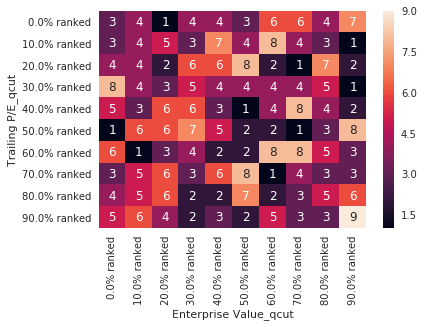

In [101]:
sns.heatmap(crosstab, annot=True)

In [237]:
data = [
     go.Contour(
        z=neo_data ,
        colorscale='Jet',
    )]
py.iplot(data)


TypeError: Object of type 'DataFrame' is not JSON serializable

In [109]:
import colorlover as cl

In [110]:
from IPython.display import HTML

In [57]:
dict(list(pd.DataFrame({'a': np.arange(10), 'b': np.random.rand(10)}).groupby('a')))

{0:    a         b
 0  0  0.624169, 1:    a         b
 1  1  0.291527, 2:    a        b
 2  2  0.36983, 3:    a         b
 3  3  0.891637, 4:    a         b
 4  4  0.885553, 5:    a         b
 5  5  0.612453, 6:    a         b
 6  6  0.445963, 7:    a         b
 7  7  0.906404, 8:    a         b
 8  8  0.370396, 9:    a         b
 9  9  0.916095}

In [86]:
two_elem = lambda : np.random.choice(['a','b','c'],2)

df = pd.DataFrame({str(i) : two_elem() for i in range(10)})
print(df)
print(df.stack())
print(df.stack().reset_index()[[0]].T)


   0  1  2  3  4  5  6  7  8  9
0  a  a  b  a  c  a  c  b  c  c
1  c  a  c  c  a  c  b  b  c  a
0  0    a
   1    a
   2    b
   3    a
   4    c
   5    a
   6    c
   7    b
   8    c
   9    c
1  0    c
   1    a
   2    c
   3    c
   4    a
   5    c
   6    b
   7    b
   8    c
   9    a
dtype: object
  0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19
0  a  a  b  a  c  a  c  b  c  c  c  a  c  c  a  c  b  b  c  a


In [10]:
from collections import namedtuple
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits


def _10K_string_cleaner(_10K):
    # Lowercase the text
    _10K = _10K.lower()
    stopchar = punctuation + digits + '’“”'
    for ch in stopchar:
        # Replace stopchar by whitespace
        _10K = _10K.replace(ch, ' ')
    # Tokenize
    _10K = word_tokenize(_10K)
    # Remove stopwords
    _10K = [word for word in _10K if word not in stopwords.words('english')]
    return _10K


corpus = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(data['Latest 10K']):
    corpus.append(analyzedDocument(_10K_string_cleaner(text), [i]))